# Working with Decision Trees
*Curtis Miller*

A **decision tree** is a classification algorithm where a series of true/false questions about the data are answered to predict the value of a target variable. This usually is visualized by a tree that one traces to make predictions. A nice feature of this algorithm is that it's a heuristic a human can easily interpret and use. However, decision trees are especially prone to overfitting.

Decision tree classifiers can be implemented using the **scikit-learn** class `DecisionTreeClassifier`. The algorithm tries to train a decision tree that quickly makes accurate decisions on training data.

The hyperparameter I want to draw particular attention to is the maximum depth a decision tree may have. Trees with high depth may be more prone to overfitting with trees with low depth, while trees with low depth may underfit.

We will see how well decision trees predict who survived the *Titanic* disaster. I load in the *Titanic* dataset below.

In [1]:
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report

In [2]:
titanic = pd.read_csv("titanic.csv")
titanic.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [3]:
titanic_train, titanic_test = train_test_split(titanic)
titanic_train.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
694,1,3,Miss. Katherine Mullens,female,19.0,0,0,7.7333
261,0,1,Mr. William Harrison,male,40.0,0,0,0.0000
145,1,3,Mr. August Edvard Andersson,male,27.0,0,0,7.7958
177,0,2,Mr. Reginald Hale,male,30.0,0,0,13.0000
635,0,3,Mrs. Juha (Maria Emilia Ojala) Panula,female,41.0,0,5,39.6875


## Fitting a Decision Tree

We will fit a decision tree without specifying a maximum depth. We will also visualize the tree. (I grabbed the code for visualizing the tree from a [blog post by "Russel"](https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176).)

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [5]:
tree1 = DecisionTreeClassifier()

tree1 = tree1.fit(X=titanic_train.replace({'Sex': {'male': 0, 'female': 1}}    # Replace strings with numbers
                                         ).drop(["Survived", "Name"], axis=1),
                  y=titanic_train.Survived)

# Example prediction
tree1.predict([[2, 0, 26, 0, 0, 30]])    # A male in second class age 26 with no spouse or child aboard who paid $30 fare

array([1], dtype=int64)

In [6]:
pred1 = tree1.predict(titanic_train.replace({'Sex': {'male': 0, 'female': 1}}
                                           ).drop(["Survived", "Name"], axis=1))
print(classification_report(titanic_train.Survived, pred1))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       412
          1       1.00      0.97      0.98       253

avg / total       0.99      0.99      0.99       665



We can see that on the training data the algorithm is highly accurate, but there's a good chance the model overfit the data.

We can visualize the resulting tree like so. (You will need to install [Graphviz](http://www.graphviz.org/), an open source software package for visualizing graphs, including decision trees.)

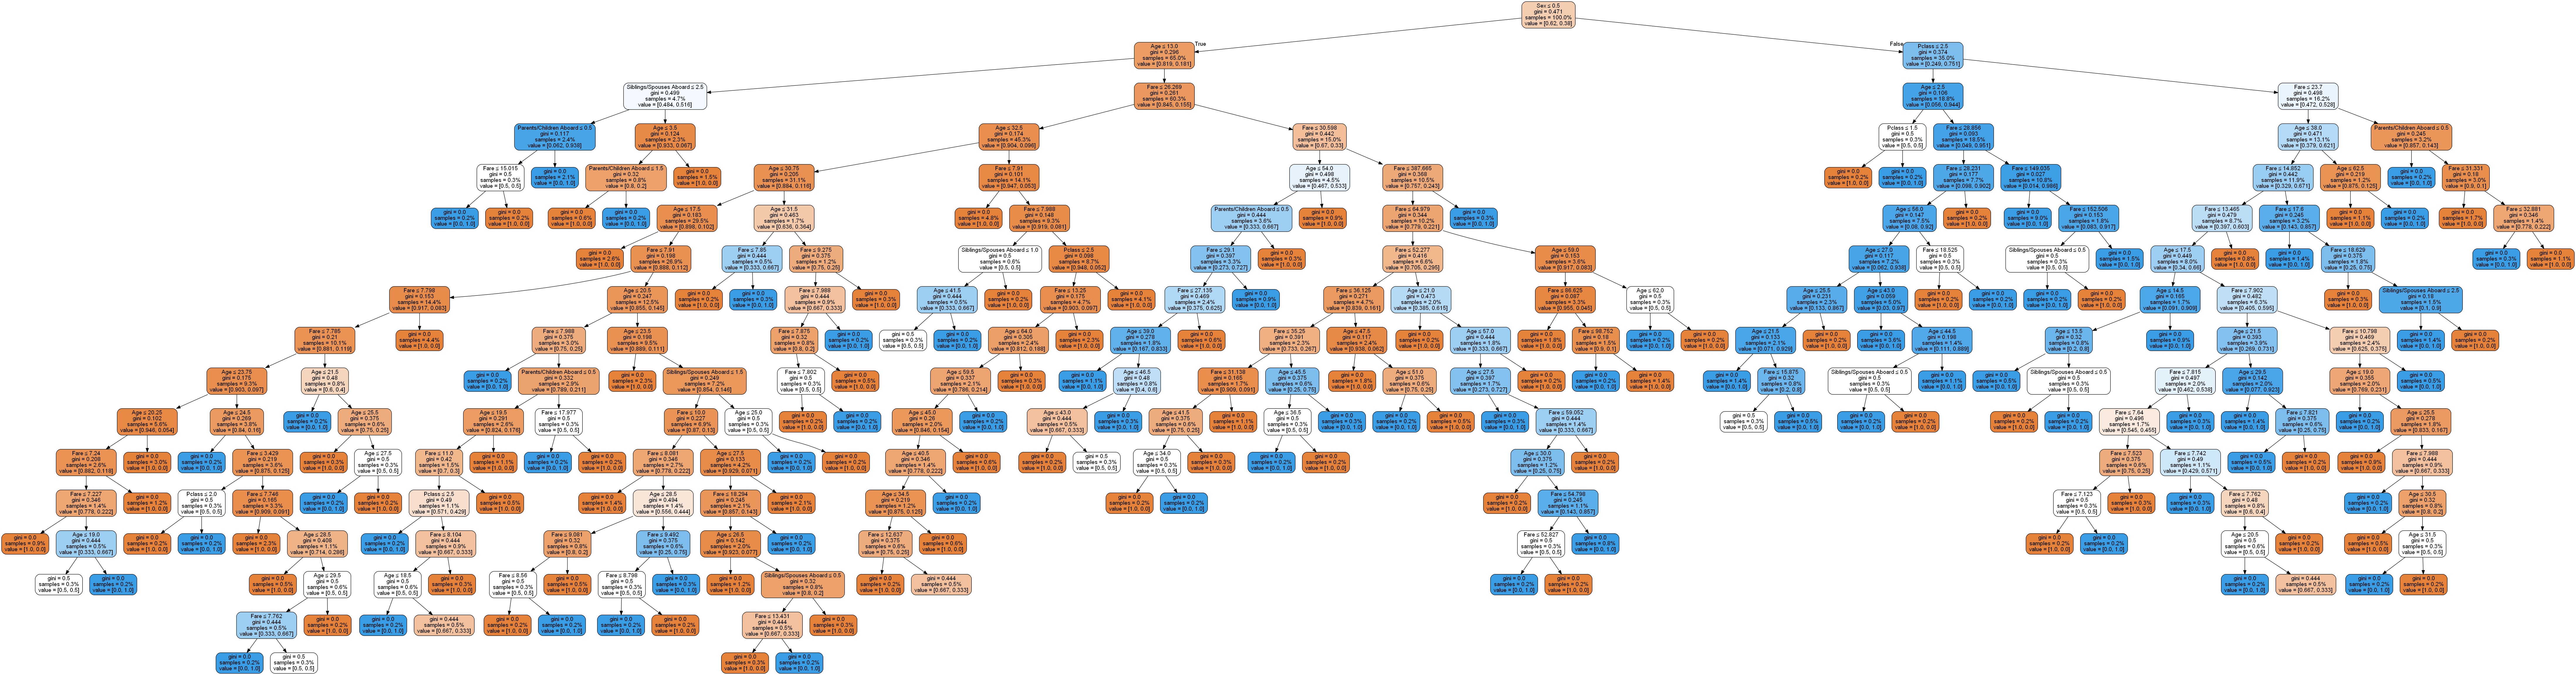

In [7]:
# From here: https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
dot_data = StringIO()

export_graphviz(tree1,    # Function for exporting a visualization of the tree
                out_file=dot_data,
                # Data controlling the display of the graph
                filled=True, rounded=True,
                special_characters=True,
                feature_names=["Pclass", "Sex", "Age", "Siblings/Spouses Aboard", "Parents/Children Aboard",
                               "Fare"],    # Use the name of the features
                proportion=True)    # Show proportions for labels

# Display graph in Jupyter notebook
graph1 = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph1.create_png())

A graph this complex is probably overfitting. In fact, let's peek to see how this would do on the test data.

In [8]:
pred2 = tree1.predict(titanic_test.replace({'Sex': {'male': 0, 'female': 1}}
                                          ).drop(["Survived", "Name"], axis=1))
print(classification_report(titanic_test.Survived, pred2))

             precision    recall  f1-score   support

          0       0.83      0.78      0.80       133
          1       0.70      0.75      0.72        89

avg / total       0.77      0.77      0.77       222



Performance dropped significantly. This is likely no better than the "predict most frequent label" algorithm.

## Restricting Tree Depth

We can control overfitting by restricting the depth of the tree. For example, let's see a tree that does not go deeper than three levels.

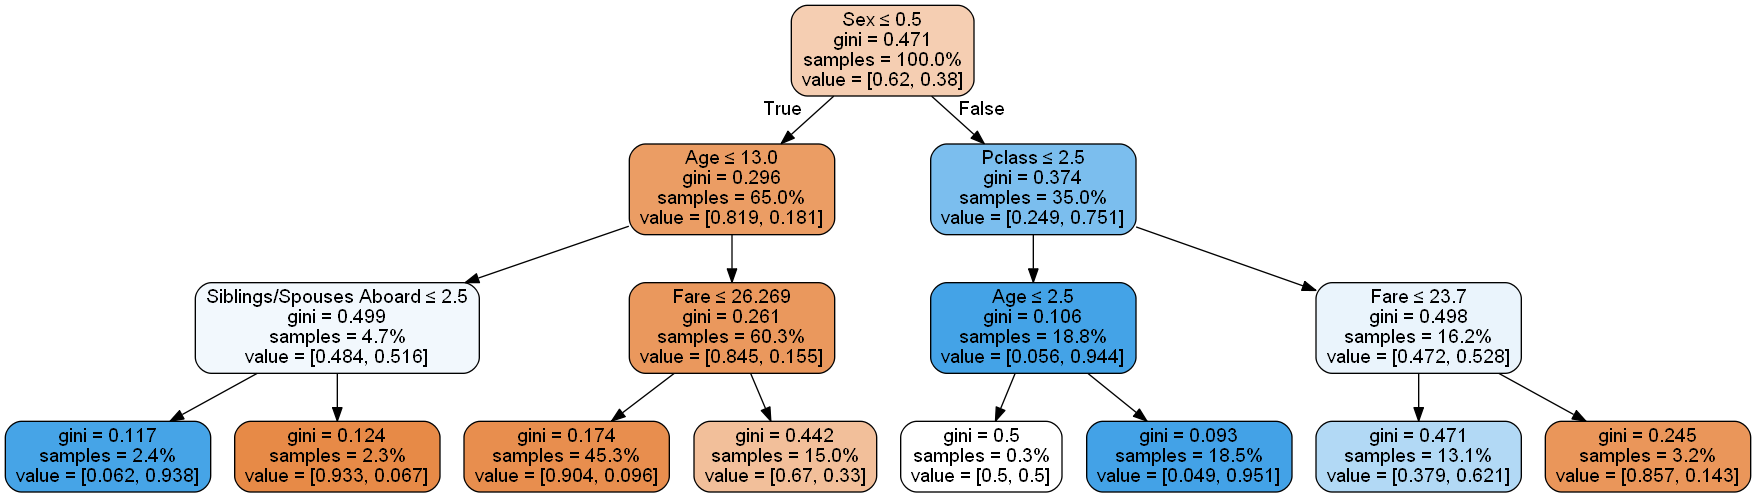

In [9]:
tree2 = DecisionTreeClassifier(max_depth=3)

tree2 = tree2.fit(X=titanic_train.replace({'Sex': {'male': 0, 'female': 1}}    # Replace strings with numbers
                                         ).drop(["Survived", "Name"], axis=1),
                  y=titanic_train.Survived)

dot_data = StringIO()

export_graphviz(tree2,    # Function for exporting a visualization of the tree
                out_file=dot_data,
                # Data controlling the display of the graph
                filled=True, rounded=True,
                special_characters=True,
                feature_names=["Pclass", "Sex", "Age", "Siblings/Spouses Aboard", "Parents/Children Aboard",
                               "Fare"],
                proportion=True)

# Display graph in Jupyter notebook
graph2 = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph2.create_png())

Now let's use cross-validation to decide the appropriate tree depth.

In [10]:
m_candidate = [2, 3, 4, 5, 6, 7, 8, 9, 10]    # Candidate depths
res = dict()

for m in m_candidate:
    pred3 = DecisionTreeClassifier(max_depth=m)
    res[m] = cross_validate(pred3,
                            X=titanic_train.replace({'Sex': {'male': 0, 'female': 1}}    # Replace strings with numbers
                                         ).drop(["Survived", "Name"], axis=1),
                            y=titanic_train.Survived,
                            cv=10,
                            return_train_score=False,
                            scoring='accuracy')

resdf = DataFrame({(i, j): res[i][j]
                             for i in res.keys()
                             for j in res[i].keys()}).T

resdf.loc[(slice(None), 'test_score'), :]

,,0,1,2,3,4,5,6,7,8,9
2,test_score,0.764706,0.764706,0.805970,0.848485,0.803030,0.787879,0.757576,0.848485,0.772727,0.742424
3,test_score,0.808824,0.808824,0.820896,0.878788,0.818182,0.803030,0.757576,0.833333,0.848485,0.803030
4,test_score,0.808824,0.823529,0.850746,0.893939,0.848485,0.803030,0.757576,0.833333,0.833333,0.803030
5,test_score,0.823529,0.823529,0.865672,0.863636,0.848485,0.803030,0.757576,0.833333,0.833333,0.818182
6,test_score,0.794118,0.852941,0.835821,0.848485,0.818182,0.772727,0.757576,0.833333,0.803030,0.787879
7,test_score,0.838235,0.823529,0.820896,0.833333,0.803030,0.772727,0.742424,0.818182,0.803030,0.803030
8,test_score,0.779412,0.808824,0.835821,0.848485,0.787879,0.757576,0.757576,0.803030,0.848485,0.772727
9,test_score,0.852941,0.779412,0.850746,0.833333,0.787879,0.757576,0.772727,0.833333,0.848485,0.787879
10,test_score,0.779412,0.808824,0.791045,0.833333,0.757576,0.757576,0.742424,0.833333,0.848485,0.772727


In [11]:
resdf.loc[(slice(None), 'test_score'), :].mean(axis=1)

2   test_score    0.789599
3   test_score    0.818097
4   test_score    0.825583
5   test_score    0.827031
6   test_score    0.810409
7   test_score    0.805842
8   test_score    0.799981
9   test_score    0.810431
10  test_score    0.792473
dtype: float64

Maximum predictive accuracy occurs when the maximum depth is 5. Let's see the final result.

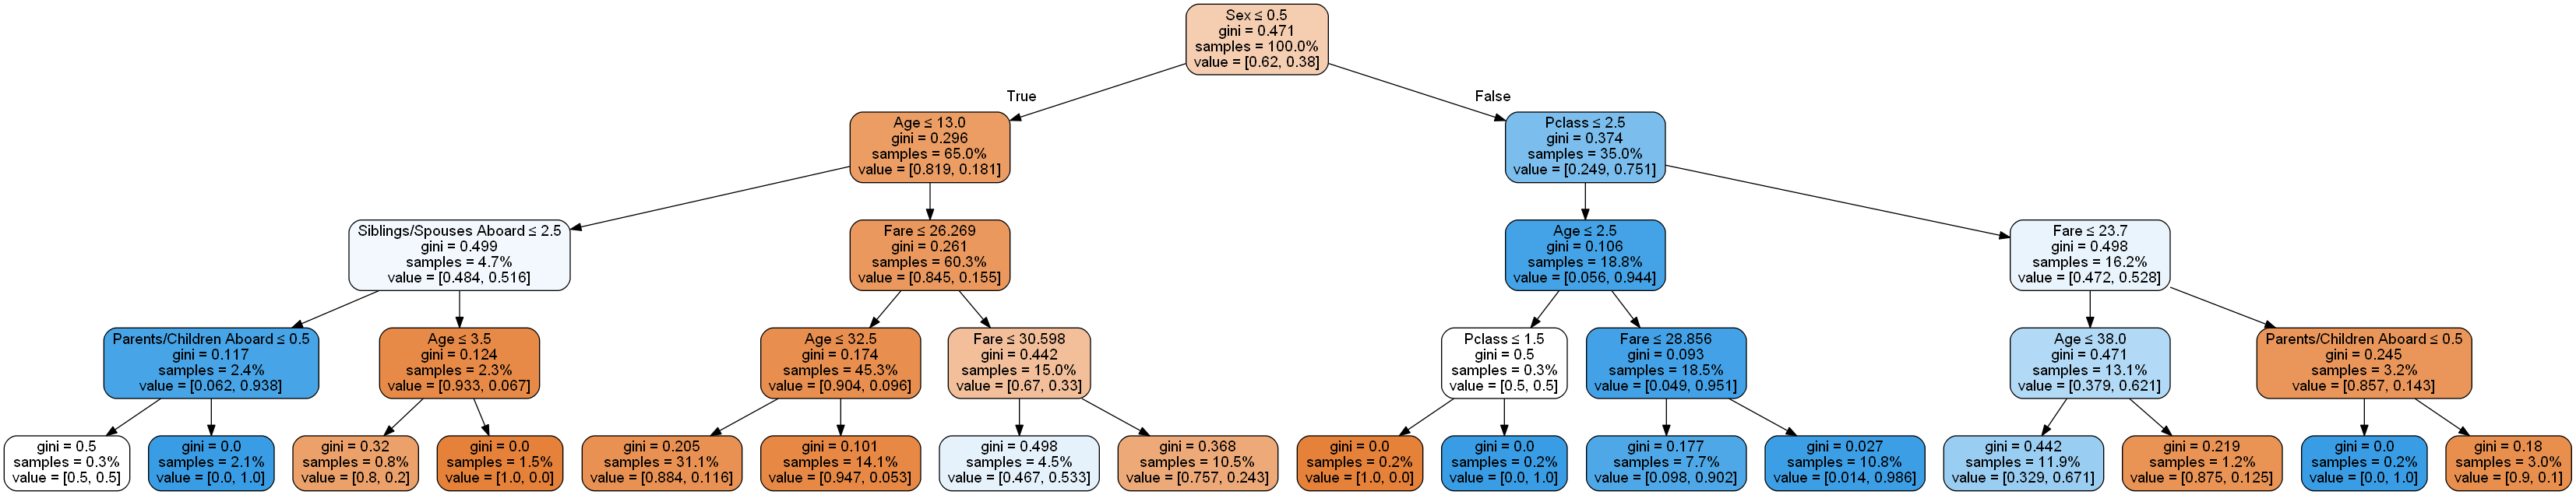

In [12]:
tree4 = DecisionTreeClassifier(max_depth=4)

tree4 = tree4.fit(X=titanic_train.replace({'Sex': {'male': 0, 'female': 1}}    # Replace strings with numbers
                                         ).drop(["Survived", "Name"], axis=1),
                  y=titanic_train.Survived)

dot_data = StringIO()

export_graphviz(tree4,    # Function for exporting a visualization of the tree
                out_file=dot_data,
                # Data controlling the display of the graph
                filled=True, rounded=True,
                special_characters=True,
                feature_names=["Pclass", "Sex", "Age", "Siblings/Spouses Aboard", "Parents/Children Aboard",
                               "Fare"],
                proportion=True)

# Display graph in Jupyter notebook
graph3 = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph3.create_png())

In [13]:
survived_test_predict = tree4.predict(X=titanic_test.replace(
    {'Sex': {'male': 0, 'female': 1}}
).drop(["Survived", "Name"], axis=1))

In [14]:
print(classification_report(titanic_test.Survived, survived_test_predict))

             precision    recall  f1-score   support

          0       0.84      0.82      0.83       133
          1       0.74      0.76      0.75        89

avg / total       0.80      0.80      0.80       222



The metrics of the decision tree look good. These are better than when we allowed the tree to have any depth.